# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Примечания:  
  - Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.  
`del features_train`

## Подготовка данных

Загрузка данных и изучение общей информации. Загрузим необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import lightgbm as lgb

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor
from datetime import datetime

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error as mse

Зададим необходимые настройки

In [ ]:
pd.set_option('max_columns', 16)
STATE = 12345
cv = KFold(n_splits=3, shuffle=True, random_state=STATE)

Загрузим таблицу `autos.csv`

In [ ]:
autos = pd.read_csv('/datasets/autos.csv', sep=',', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

Оценим структуру данных таблиц `autos`

In [ ]:
print('Структура данных таблицы autos:')
autos.info()
display(autos.sample(5))

Структура данных таблицы autos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPict

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
67482,2016-03-29 19:44:32,2500,wagon,2005,manual,141,6_reihe,150000,8,lpg,mazda,yes,2016-03-29,0,40699,2016-04-04 04:45:02
113831,2016-03-10 12:57:12,350,small,1999,manual,60,polo,150000,4,petrol,volkswagen,NaN,2016-03-10,0,40472,2016-03-28 23:47:03
289384,2016-03-09 17:54:12,6500,wagon,2006,auto,140,octavia,150000,9,gasoline,skoda,no,2016-03-09,0,78354,2016-03-12 03:17:46
287341,2016-04-07 08:06:37,4700,small,2009,NaN,0,ka,80000,3,petrol,ford,NaN,2016-04-07,0,65232,2016-04-07 08:25:24
19631,2016-03-31 23:55:25,3950,wagon,2007,manual,120,vectra,150000,6,gasoline,opel,no,2016-03-31,0,49824,2016-04-07 04:16:31


Найдем характерные значения таблицы `autos`

In [ ]:
display(autos.describe(datetime_is_numeric=True, include='all').T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
DateCrawled,354369,NaN,NaN,NaN,2016-03-21 12:58:10.450648320,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,0.0,1050.0,2700.0,6400.0,20000.0,4514.158514
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,1000.0,1999.0,2003.0,2008.0,9999.0,90.227958
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,0.0,69.0,105.0,143.0,20000.0,189.850405
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,5000.0,125000.0,150000.0,150000.0,150000.0,37905.34153
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,0.0,3.0,6.0,9.0,12.0,3.726421
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Найдем `min` и `max` для столбцов с типом данных `object`

In [ ]:
for column in autos:
    columnSeriesObj = autos[column]
    if columnSeriesObj.dtypes == object:
        print('Поле',columnSeriesObj.name,':',columnSeriesObj.astype(str).min(), '(min);', columnSeriesObj.astype(str).max(),'(max)')

Поле VehicleType : bus (min); wagon (max)
Поле Gearbox : auto (min); nan (max)
Поле Model : 100 (min); zafira (max)
Поле FuelType : cng (min); petrol (max)
Поле Brand : alfa_romeo (min); volvo (max)
Поле NotRepaired : nan (min); yes (max)


Определим уникальные значения текстовых стобцов `object`

In [ ]:
for column in autos:
    columnSeriesObj = autos[column]
    if columnSeriesObj.dtypes == object:
        print('Список уникальных значений поля', columnSeriesObj.name,':', columnSeriesObj.unique())

Список уникальных значений поля VehicleType : [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Список уникальных значений поля Gearbox : ['manual' 'auto' nan]
Список уникальных значений поля Model : ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia'

Определим количество дублей

In [ ]:
print('Количество дублей', autos.duplicated().sum())

Количество дублей 4


Найдем пропущенные значения `NaN` в столбцах таблицы `autos`

In [ ]:
autos.isnull().sum().sort_values(ascending = False)

NotRepaired          71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Найдем нулевые значения в столбцах таблицы `autos`

In [ ]:
autos.isin([0]).sum().sort_values(ascending = False)

NumberOfPictures     354369
Power                 40225
RegistrationMonth     37352
Price                 10772
DateCrawled               0
VehicleType               0
RegistrationYear          0
Gearbox                   0
Model                     0
Kilometer                 0
FuelType                  0
Brand                     0
NotRepaired               0
DateCreated               0
PostalCode                0
LastSeen                  0
dtype: int64

#### Вывод:  
Таблица `autos.csv` состоит из 354369 строк и 16 столбцов (разделитель - запятая):  
- **DateCrawled** - дата скачивания анкеты из базы (тип - datetime64)  

- **Price** - цена, евро (тип - int64), целевой признак  
> обнаружено 10772 нулевых значений (3%)  
> обработка нулевых значений: уберем строки с нулевыми значениями, так как их объем в общей выборке невелик

**VehicleType** - тип автомобильного кузова (тип - object)  
- категорийный признак;
> пропущено 37490 значений (10,5%)

**RegistrationYear** - год регистрации автомобиля (тип - int64)
> обнаружены выбросы (значения 1000; 9999)
> обработка выбросов: можно попробовать ограничить данные 1985 и 2020 годами (процент выбросов невелик: 1.57%), удалив остальные значения

**Gearbox** - тип коробки передач (тип - object)
- категорийный признак;
> пропущено 19833 значений (5,6%)

**Power** - мощность, л. с. (тип - int64)
> обнаружено 40225 нулевых значений (11%);
> обнаружены выбросы (значения 0; 20000);
> обработка пропусков и выбросов: ограничить автомобилями до 500 л.с.

**Model** - модель автомобиля (тип - object)
- категорийный признак;
> пропущено 19705 значений (5,6%)

**Kilometer** - пробег, км (тип - int64)  

**RegistrationMonth** - месяц регистрации автомобиля (тип - int64)
- категорийный признак;
> обнаружено 37352 нулевых значений (10,5%)

**FuelType** - тип топлива (тип - object)
- категорийный признак;
> пропущено 32895 значений (9%)

**Brand** - марка автомобиля (тип - object)
- категорийный признак;

**NotRepaired** - была машина в ремонте или нет (тип - object)
- категорийный признак;
> пропущено 71154 значений (20%)

**DateCreated** - дата создания анкеты (тип - datetime64)

**NumberOfPictures** - количество фотографий автомобиля (тип - int64)
>все значения равны нулю - поле можно удалить

**PostalCode** - почтовый индекс владельца анкеты (тип - int64)  
>Странные значения почтовых индексов (явно не РФ) для сервиса с названием "Не бит, не крашен"

**LastSeen** - дата последней активности пользователя (тип - datetime64)  

Качество данных вызывает вопросы: видим пропущенные и нулевые значения, выбросы  


План подготовки данных:

Удалить полные дубли  
Удалить строки с пропущенными значениями поле price, так как их объем в общей выборке невелик  
Удалить признаки, не влияющие на стоимость автомобиля: **DateCrawled, DateCreated, RegistrationMonth, NumberOfPictures, LastSeen**  

Пропуски в категориальных признаках выделить в отдельную категорию "nan"  
Обработать строки со значениями в поле RegistrationYear   
Значения выбросы в поле Power удалить
Изменить тип данных категориальных переменных на category (для работы LGBMRegressor)  
При необходимости преобразовать категориальные признаки в численные при помощи техники прямого кодирования (OHE) - для линейных моделей

### Анализ и подготовка данных

Целевой признак - **Price** посмотрим распределение и наличие нулей/очень малых цен

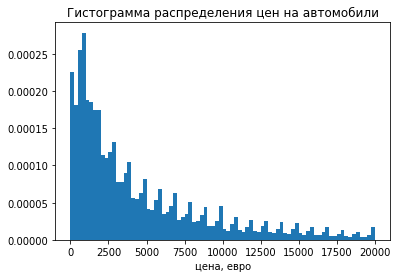

In [ ]:
plt.hist(autos['Price'], bins=80, density=True)
plt.title('Гистограмма распределения цен на автомобили')
plt.xlabel('цена, евро')
plt.show()

Нулевые значения цены - это отсутствующие данные. Эти объекты удаляем, т.к. модель нельзя обучить прогнозу целевого признака без самого целевого признака.  
Возможная причина возникновения нулевых значений - ошибка выгрузки базы данных, пользователи вводили данные не внимательно или ставили произволную цифру, чтобы потенциальный покупатель связывался с покупателем.

In [ ]:
print('Объектов с нулевой ценой:', autos[autos['Price']==0].shape[0])
autos.drop(index=autos[autos['Price']==0].index, inplace=True)
print('Очищено')
print('Объектов с нулевой ценой:', autos[autos['Price']==0].shape[0])

Объектов с нулевой ценой: 10772
Очищено
Объектов с нулевой ценой: 0


Посмотрим сколько объектов ценой менее 50 евро

In [ ]:
print('Объектов стоимостью до 50 евро включительно:', len(autos[autos['Price']<50]))

Объектов стоимостью до 50 евро включительно: 1651


Объекты стоимостью до 50 евров - выглядят подозрительно, а количеством 1651 можно принебречь, удалив эти данные. Так же посмотрим на получившееся распределение

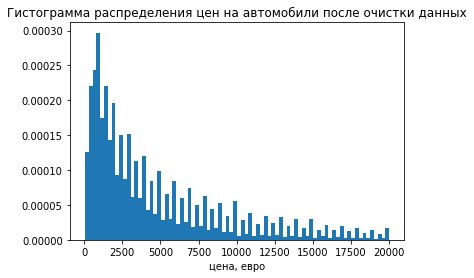

In [ ]:
autos.drop(index=autos[autos['Price']<50].index, inplace=True)

plt.hist(autos['Price'], bins=80, density=True)
plt.title('Гистограмма распределения цен на автомобили после очистки данных')
plt.xlabel('цена, евро')
plt.show()

Посмотрим на столбец **RegistrationYear**

In [ ]:
autos['RegistrationYear'].describe()

count    341946.000000
mean       2004.079741
std          77.070546
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Обработаем выбросы. Выделим объекты, которые "моложе" даты объявления о своей продаже

In [ ]:
too_young_1 = (autos['RegistrationYear'] - autos['DateCreated'].dt.year) > 0

too_young_2 = (
    ((autos['RegistrationYear'] - autos['DateCreated'].dt.year) == 0)
    &
    ((autos['RegistrationMonth'] - autos['DateCreated'].dt.month) > 0)
)

too_young = too_young_1 | too_young_2

print('Объектов, которые "моложе" даты своей продажи:', too_young.sum())

autos[too_young].head()

Объектов, которые "моложе" даты своей продажи: 18636


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08,0,19386,2016-03-08 09:44:50
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44


Объектов, которые "моложе" даты своей продажи довольно много, удалять их не будем, заполним некорректные года и месяцы на `NaN`

In [ ]:
autos.loc[too_young, 'RegistrationYear'] = np.nan
autos.loc[too_young, 'RegistrationMonth'] = np.nan

Обработаем слишком старые автомобили, старше 1900 года, заменим так же на `NaN`

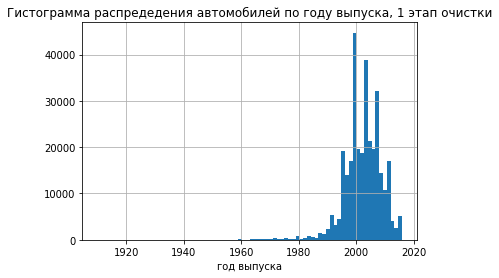

In [ ]:
autos.loc[autos.loc[:, 'RegistrationYear'] < 1900, 'RegistrationYear'] = np.nan

autos['RegistrationYear'].hist(bins=80)
plt.title('Гистограмма распредедения автомобилей по году выпуска, 1 этап очистки')
plt.xlabel('год выпуска')
plt.show()

In [ ]:
print('99.5% объектов моложе', autos['RegistrationYear'].quantile(0.005), 'года')

99.5% объектов моложе 1972.0 года


Автомобили старше 60-70-х годов можно считать ретро-автомобилями, в таких объявлениях встречается много ошибок. Заменим для таких автомобилей года регистрации на `NaN` т.к. они только вредят для анализа.

In [ ]:
print('Объектов старше 1960 г.:', len(autos[autos['RegistrationYear'] <= 1960]))
autos.loc[autos.loc[:, 'RegistrationYear'] < 1960, 'RegistrationYear'] = np.nan

Объектов старше 1960 г.: 387


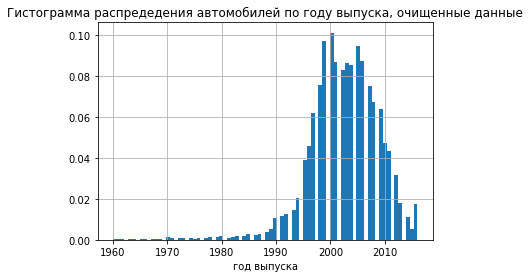

In [ ]:
autos['RegistrationYear'].hist(bins=80, density=True)
plt.title('Гистограмма распредедения автомобилей по году выпуска, очищенные данные')
plt.xlabel('год выпуска')
plt.show()

Распределение выглядит ожидаемо, с длинным хвостом слева

Посмотрим на **RegistrationMonth**

In [ ]:
autos['RegistrationMonth'].value_counts(normalize=True)

3.0     0.100912
6.0     0.089617
0.0     0.088760
4.0     0.083793
5.0     0.082924
7.0     0.077845
10.0    0.074801
11.0    0.069509
12.0    0.069348
9.0     0.068510
1.0     0.067557
8.0     0.064313
2.0     0.062111
Name: RegistrationMonth, dtype: float64

В данных есть месяц 0. Видимо, это объекты, для которых месяц был неизвестен. Это 9.5% данных. Дата регистрации автомобиля важна с точки зрения определения возраста автомобиля на момент продажи. Его можно рассчитать в годах и месяцах, вычитая дату регистрации из даты публикации анкеты. Заменим 0 на `NaN`

In [ ]:
autos.loc[autos.loc[:, 'RegistrationMonth'] == 0, 'RegistrationMonth'] = np.nan

Посмотрим на даты создания анкет **DateCreated** и выгрузки данных **DateCrawled**

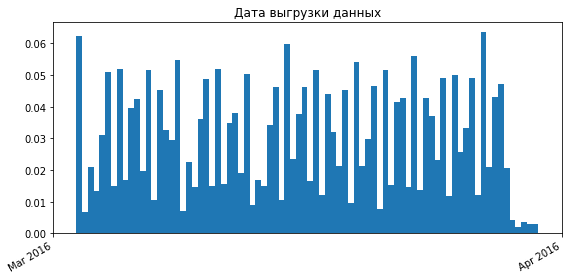

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(autos['DateCrawled'], bins=80, density=True)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.set_title('Дата выгрузки данных')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

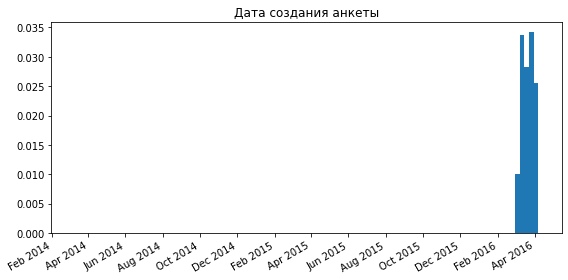

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(autos['DateCreated'], bins=100, density=True)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.set_title('Дата создания анкеты')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Почти все анкеты созданы в 2016 году, однако есть и более старые

Судя по всему, после продажи автомобиля объявление из базы удаляется. Добавим признак, который указывает, сколько объявление уже было размещено в базе к моменту выгрузки данных. Для этого найдем разницу **DateCrawled** - **DateCreated**

Алгоритм должен рекомендовать клиенту такую стоимость автомобиля, за которую его можно продать в разумные сроки. Например, в пределах месяца. Посмотрим, есть ли объявления, размещённые 30 и более дней

In [ ]:
time_exposition = autos['DateCrawled'] - autos['DateCreated']

print('Объявлений страше 30 дней:', len(autos[time_exposition.dt.days > 30]))

Объявлений страше 30 дней: 181


Уберем эти объявления, т.к. клиенту нужно рекомендовать адекватные цены

In [ ]:
autos.drop(autos[time_exposition.dt.days > 30].index, inplace=True)

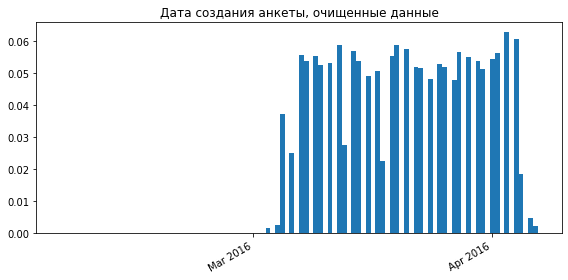

Объявлений, размещённых до марта (в феврале) 2016: 307


In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(autos['DateCreated'], bins=100, density=True)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.set_title('Дата создания анкеты, очищенные данные')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print('Объявлений, размещённых до марта (в феврале) 2016:', len(autos[autos.loc[:, 'DateCreated'].dt.month == 2]))

Удалим признаки, не влияющие на стоимость автомобиля

In [ ]:
autos = autos.drop(columns=['DateCrawled', 'DateCreated', 'RegistrationMonth', 'NumberOfPictures', 'LastSeen'])
print("Размер итоговой таблицы:", autos.shape)

Размер итоговой таблицы: (341765, 11)


Изучим столбец **Power**

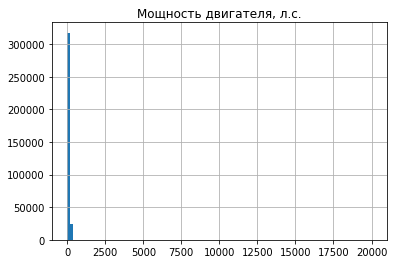

In [ ]:
autos['Power'].hist(bins=100)
plt.title('Мощность двигателя, л.с.')
plt.show()

Избавимся от выбросов, заменим NaN всё, что более 500 л.с. Также заменим на NaN нулевые значения (которые, по сути, и являются NaN)

In [ ]:
autos.loc[autos.loc[:, 'Power'] > 500, 'Power'] = np.NaN
autos.loc[autos.loc[:, 'Power'] == 0, 'Power'] = np.NaN

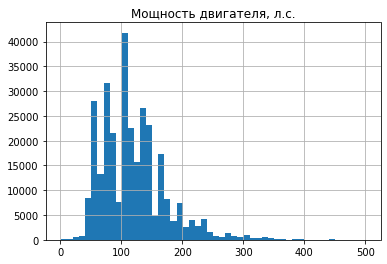

In [ ]:
autos['Power'].hist(bins=50)
plt.title('Мощность двигателя, л.с.')
plt.show()

Посмотрим столбец **Kilometer**

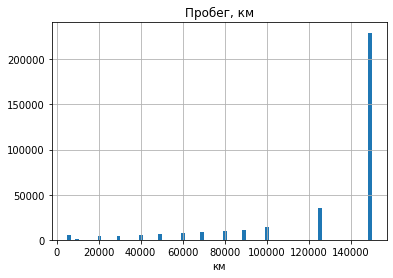

In [ ]:
autos['Kilometer'].hist(bins=80)
plt.title('Пробег, км')
plt.xlabel('км')
plt.show()

Аномалий нет, оставляем всё как есть

Посмотрим на явные дубликаты

In [ ]:
print('Количество дублей', autos.duplicated().sum())

Количество дублей 22546


Избавимся от дублей

In [ ]:
autos.drop_duplicates(inplace = True)
print("Размер итоговой таблицы:", autos.shape)

Размер итоговой таблицы: (319219, 11)


Выделим количественные и категориальные переменные, а пропуски в категориальных признаках выделим в отдельную категорию "nan"

In [ ]:
num_features = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType','Brand', 'NotRepaired']

autos[cat_features] = autos[cat_features].fillna('nan')
autos.isnull().sum().sort_values(ascending = False)

Power               34285
RegistrationYear    18147
Price                   0
VehicleType             0
Gearbox                 0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
NotRepaired             0
PostalCode              0
dtype: int64

In [ ]:
print("Размер итоговой таблицы:", autos.shape)

Размер итоговой таблицы: (319219, 11)


Изменим тип данных категориальных переменных на category (для LGBMRegressor)

In [ ]:
autos[cat_features] = autos[cat_features].astype('category')

#### Вывод:  
Данные подготовлены для решения задачи

## Обучение моделей

Разобъем данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 (т.к. спрятанной тестовой выборки нет)

In [ ]:
df_80, df_test = train_test_split(autos, test_size=0.20, random_state=STATE)
df_train, df_valid = train_test_split(df_80, test_size=0.25, random_state=STATE) # 0.25 x 0.8 = 0.2

Создадим переменные для признаков и целевого признака

In [ ]:
features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']

features_valid = df_valid.drop(['Price'], axis=1)
target_valid = df_valid['Price']

features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price']

features_train_full = df_80.drop(['Price'], axis=1)
target_train_full = df_80['Price']

Проконтролируем размер новых выборок

In [ ]:
print("Размер features_train:", features_train.shape)
print("Размер features_train:", target_train.shape)

print("Размер features_train:", features_valid.shape)
print("Размер features_train:", target_valid.shape)

print("Размер features_train:", features_test.shape)
print("Размер features_train:", target_test.shape)

print("Размер features_train:", features_train_full.shape)
print("Размер features_train:", target_train_full.shape)

Размер features_train: (191531, 10)
Размер features_train: (191531,)
Размер features_train: (63844, 10)
Размер features_train: (63844,)
Размер features_train: (63844, 10)
Размер features_train: (63844,)
Размер features_train: (255375, 10)
Размер features_train: (255375,)


Определим функцию для сбора метрик работы модели

In [ ]:
from time import *
def get_metrics(model, train_x , train_y , test_x , test_y):
    result = {}

    # Определение времени обучения модели
    start = time()
    model.fit(train_x,train_y)
    end = time()
    result['train_time'] = end-start

    # Определение времени предсказания модели
    start = time()
    test_y_predict = model.predict(test_x)
    end = time()
    result['prediction_time'] = end - start

    # Определим RMSE

    result['RMSE'] = mse(test_y, test_y_predict)**0.5

    print('model_type {}'.format(model))
    return result

Обучение моделей  


Построим модели для определения стоимости.
Возьмем две модели из библиотек градиентного бустинга:  
1. LGBMRegressor;
2. CatBoostRegressor

И линейную модель

3. LinearRegression

Построим модель градиентного бустинга LGBMRegressor

In [ ]:
model_lgbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=STATE)

parameters = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
#     'force_row_wise': [True]
}

model_lgbm_grid = GridSearchCV(model_lgbm,
                        parameters,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=True)

Подберем оптимальные гиперпараметры для LGBMRegressor

In [ ]:
%%time
model_lgbm_grid.fit(features_train, target_train)
model_lgbm_grid.best_params_

Получим метрики работы модели LGBMRegressor

In [ ]:
values1 = get_metrics(model_lgbm_grid.best_estimator_, features_train, target_train, features_valid, target_valid)

Используем библиотеку Catboost. Построим модель градиентного бустинга CatBoostRegressor

In [ ]:
model_catboost = CatBoostRegressor(random_seed=STATE,
                        loss_function='RMSE',
                        silent=True,
                        cat_features=cat_features)

parameters = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [6, 8, 10],
}

model_catboost_grid = GridSearchCV(model_catboost,
                        parameters,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=False)

Подберем оптимальные гиперпараметры для CatBoostRegressor

In [ ]:
%%time
model_catboost_grid.fit(features_train, target_train)
model_catboost_grid.best_params_

Получим метрики работы модели CatBoostRegressor

In [ ]:
values2 = get_metrics(model_catboost_grid.best_estimator_, features_train, target_train, features_valid, target_valid)

Построим модель линейной регресии (LinearRegression). Создадим цепочку конвейерной обработки sklearn.pipeline

In [ ]:
features_train.head(3)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
309306,small,2001.0,manual,58.0,twingo,5000,petrol,renault,nan,39118
308594,other,1999.0,manual,101.0,focus,150000,petrol,ford,yes,48231
183028,small,1997.0,manual,60.0,golf,150000,petrol,volkswagen,nan,97720


In [ ]:
numeric_features = ['RegistrationYear', 'Power', 'Kilometer', 'PostalCode']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


model_linearregression_pipe = Pipeline(
    steps=[("preprocessor", preprocessor),
    ("classifier", LinearRegression())
])

In [ ]:
input_data = preprocessor.fit_transform(features_train)
pd.DataFrame(input_data.A[:3,])

,0,1,2,3,4,5,6,7,...,309,310,311,312,313,314,315,316
0,-0.215042,-1.159965,-3.315032,-0.455379,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.521831,-0.353252,0.574233,-0.101148,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.828621,-1.122443,0.574233,1.822536,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Обучим модель LinearRegression

In [ ]:
%%time
model_linearregression_pipe.fit(features_train, target_train)

CPU times: user 14.8 s, sys: 17.3 s, total: 32.1 s
Wall time: 32.1 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer', 'PostalCode']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'NotRepaired'])])),
                ('classifier'

Получим метрики работы модели LinearRegression

In [ ]:
values3 = get_metrics(model_linearregression_pipe, features_train, target_train, features_valid, target_valid)

model_type Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer', 'PostalCode']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'NotRepaired'])])),
                ('

### Вывод:
- Cобрали метрики работы 3-х моделей. Проанализируем их

## Анализ моделей

Сформируем таблицу метрик

In [ ]:
best_model = pd.DataFrame({'name_model':["LGBMRegressor","CatBoostRegressor","LinearRegression"],\
                       "train_time":[values1["train_time"],values2["train_time"],values3["train_time"]],\
                       "prediction_time":[values1["prediction_time"],values2["prediction_time"],values3["prediction_time"]],\
                       "RMSE":[values1["RMSE"],values2["RMSE"],values3["RMSE"]]})

Выведем на экран метрики работы моделей

In [ ]:
print('Метрики работы моделей')
display(best_model.sort_values(by =["RMSE"], ascending = True))

Метрики работы моделей


,name_model,train_time,prediction_time,RMSE
0,LGBMRegressor,3.394967,0.402072,1665.828446
1,CatBoostRegressor,7.125461,0.047881,1720.219559
2,LinearRegression,19.186854,0.248373,2628.973224


#### Вывод:
- LGBMRegressor - лучшая модель по соотношению скорости работы к качеству предсказаний

Проверим выбранную модель на тестовой выборке

In [ ]:
model = model_lgbm_grid.best_estimator_
model.fit(features_train_full, target_train_full)
prediction = model.predict(features_test)
rmse = mse(target_test, prediction, squared=False)
print('RMSE:', rmse)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
RMSE: 1650.2798332718837


### Итоговый вывод:  
В рамках проекта по созданию приложения для определения рыночной стоимости автомобилей с пробегом были построены и обучены три модели.
Лучшей моделью по соотношению скорости работы к качеству предсказаний стала LGBMRegressor с RMSE = 1665, временем обучения train_time = 3.3 и временем предсказания prediction_time = 0,4. Модель CatBoostRegressor показало самое быстрое время предсказания = 0.047 при схожем качестве, однако время обучения выше, чем у LGBMRegressor (train_time = 7.1)

Итоговое значение RMSE модели LGBMRegressor на тестовой выборке составило 1650. По заданию у нас было значение метрики RMSE должно быть меньше 2500, подходит.